src: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [20]:
from pandas import datetime
from matplotlib import pyplot
import pandas as pd

/var/folders/8f/zn20y3z53vj3ln91y64pcf2w0000gn/T/ipykernel_67079/2748079860.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


/var/folders/8f/zn20y3z53vj3ln91y64pcf2w0000gn/T/ipykernel_67079/3331354587.py:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('./shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


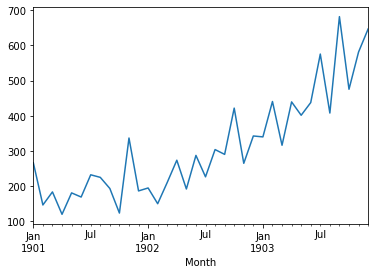

In [21]:
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('./shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
series.plot()
pyplot.show()

This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

In [22]:
from pandas.plotting import autocorrelation_plot

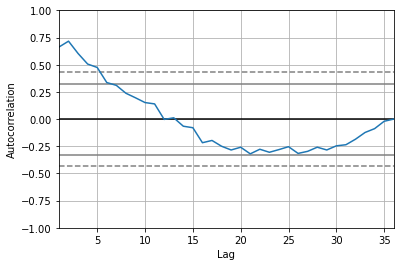

In [23]:
autocorrelation_plot(series)
pyplot.show()

we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

## ARIMA with statsmodels

First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

In [24]:
# fit an ARIMA model and plot residual errors
from statsmodels.tsa.arima.model import ARIMA

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Sun, 19 Mar 2023   AIC                            408.969
Time:                        01:06:55   BIC                            418.301
Sample:                    01-31-1901   HQIC                           412.191
                         - 12-31-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.7

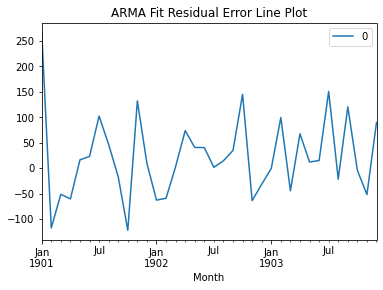

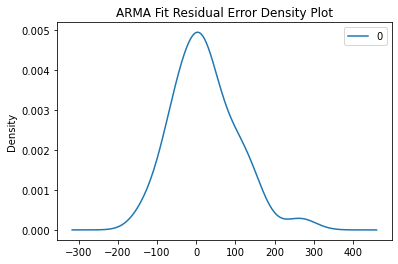

                0
count   36.000000
mean    21.936144
std     80.774430
min   -122.292030
25%    -35.040859
50%     13.147219
75%     68.848286
max    266.000000


In [25]:
series.index = series.index.to_period('M')
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot().set_title('ARMA Fit Residual Error Line Plot')
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde').set_title('ARMA Fit Residual Error Density Plot')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

# Rolling Forecast ARIMA Model

- `predict()`


If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as start=101, end=101. This would return an array with one element containing the prediction.

- `forecast() `

Alternately, we can avoid all of these specifications by using the forecast() function, which performs a one-step forecast using the model.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

predicted=343.272180, expected=342.300000
predicted=293.329674, expected=339.700000
predicted=368.668956, expected=440.400000
predicted=335.044741, expected=315.900000
predicted=363.220222, expected=439.300000
predicted=357.645324, expected=401.300000
predicted=443.047835, expected=437.400000
predicted=378.365674, expected=575.500000
predicted=459.415021, expected=407.600000
predicted=526.890876, expected=682.000000
predicted=457.231274, expected=475.300000
predicted=672.914943, expected=581.300000
predicted=531.541449, expected=646.900000
Test RMSE: 89.021


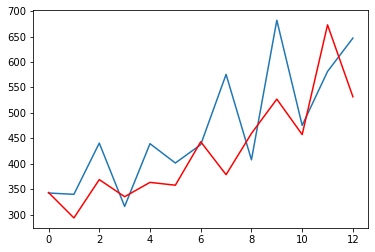

In [26]:
# evaluate an ARIMA model using a walk-forward validation
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

We can use Box-Jenkins Methodology to further tune the ARIMA model: 

In summary, the steps of this process are as follows:

- Model Identification. Use plots and summary statistics to identify trends, seasonality, and autoregression elements to get an idea of the amount of differencing and the size of the lag that will be required.
- Parameter Estimation. Use a fitting procedure to find the coefficients of the regression model.
- Model Checking. Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model.